In [209]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from ansatz_library import AngleEncoder
import numpy as np


from ionqvision.ansatze import VariationalAnsatz

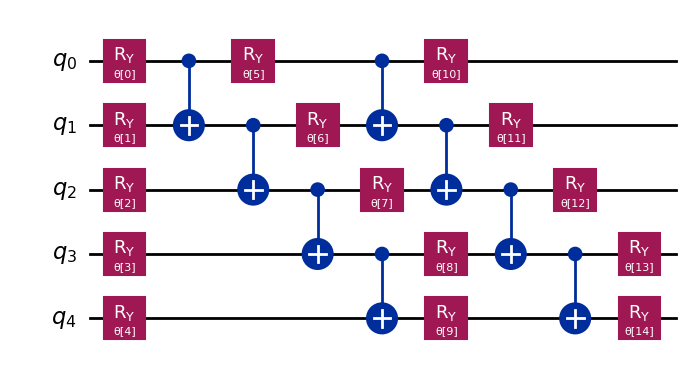

In [210]:
TwoLocal(num_qubits=5, entanglement="linear", rotation_blocks="ry", entanglement_blocks="cx", reps=2).decompose().draw("mpl")

In [211]:
class CustomZFeatureMapEncoder(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)

        x = ParameterVector(param_prefix, num)
        self.compose(ZFeatureMap(num, reps=reps, insert_barriers=True).decompose(), inplace = True)

In [212]:
class CustomEncoder(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)
        x = ParameterVector(param_prefix, num)
        enc = QuantumCircuit(num)
        for j in range(reps):
            for i in range(num):
                enc.ry(x[i], i)
        self.compose(enc, inplace=True)

In [213]:
class CustomTwoLocal(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num_qubits, reps, entanglement, rotation_blocks, entanglement_blocks,param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits)
        self.compose(TwoLocal(num_qubits=num_qubits, reps=reps, entanglement=entanglement, rotation_blocks=rotation_blocks, entanglement_blocks=entanglement_blocks,
                              insert_barriers=True).decompose(), inplace = True)

In [214]:
class CustomEfficientSU2(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num_qubits, reps, entanglement, param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits)
        self.compose(EfficientSU2(num_qubits=num_qubits, reps=reps, entanglement=entanglement, insert_barriers=True).decompose(), inplace = True)

In [215]:
n = 2

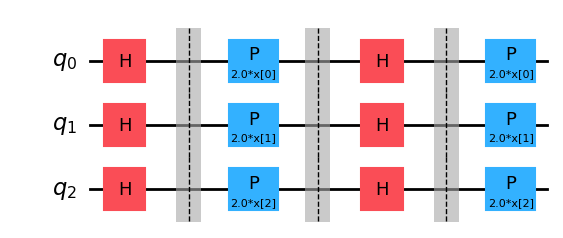

In [216]:
encoder = CustomZFeatureMapEncoder(n, reps = 2)
encoder.draw("mpl")

In [217]:
# encoder = QuantumCircuit(4)
# for i in range(4):
#     encoder.x(i)

# encoder.draw("mpl")

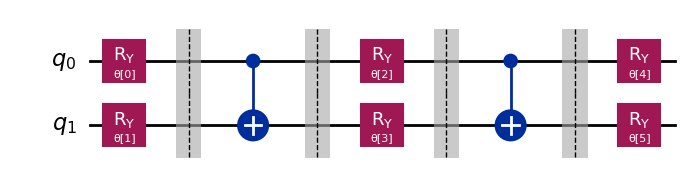

In [196]:
ansatz = CustomTwoLocal(num_qubits=n,reps=2, entanglement="linear", entanglement_blocks="cx", rotation_blocks="ry")
ansatz.draw("mpl")

In [197]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
def feature_creation(n):
    if n % 2 == 0:
        return [SparsePauliOp(["ZI"*(n//2)])]
    else:
        return [SparsePauliOp(["ZI"*(n//2) + "I"])]
           # SparsePauliOp(["YXYX"])]
            # SparsePauliOp(["I"*(n-1) + "X"]), 
            # SparsePauliOp(["I"*(n-1) + "Y"])]

quantum_features = feature_creation(n)

In [198]:
quantum_features

[SparsePauliOp(['ZI'],
               coeffs=[1.+0.j])]

In [199]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features);

In [200]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

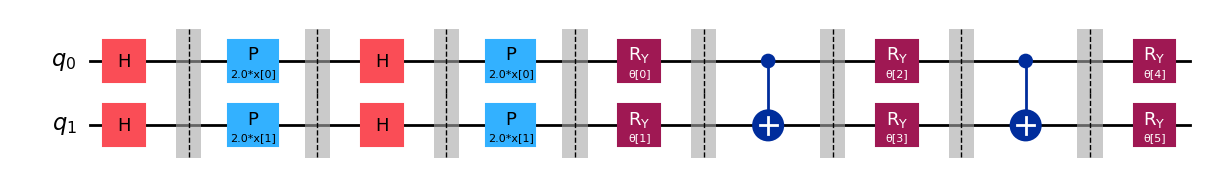

In [201]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

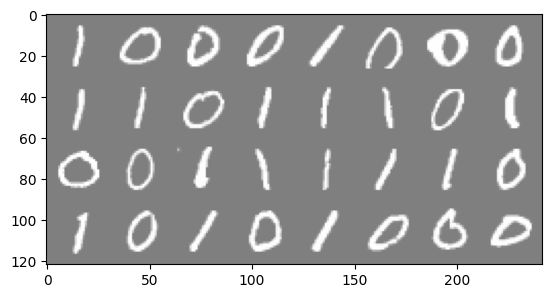

In [202]:
# Verify the images loaded correctly
classifier.visualize_batch()

In [203]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

train_set

CPU times: user 89 ms, sys: 88.6 ms, total: 178 ms
Wall time: 144 ms


Dataset MNIST
    Number of datapoints: 300
    Root location: ./mnist-train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [204]:
train_set[0][0].shape

torch.Size([1, 28, 6])

In [205]:
np.array(train_set[0][0].shape)

array([ 1, 28,  6])

epoch:   1 | loss: 0.699
lr: 0.1000 | processed    10/   12 batches per epoch in 29.93s (0.17s forward / 2.48s backward)
Model achieved 53.333%  accuracy on TRAIN set.
Model achieved 60.000%  accuracy on TEST set.

epoch:   2 | loss: 0.691
lr: 0.1000 | processed    10/   12 batches per epoch in 26.40s (0.13s forward / 2.20s backward)
Model achieved 53.333%  accuracy on TRAIN set.
Model achieved 60.000%  accuracy on TEST set.

epoch:   3 | loss: 0.690
lr: 0.1000 | processed    10/   12 batches per epoch in 26.69s (0.13s forward / 2.72s backward)
Model achieved 53.333%  accuracy on TRAIN set.
Model achieved 60.000%  accuracy on TEST set.



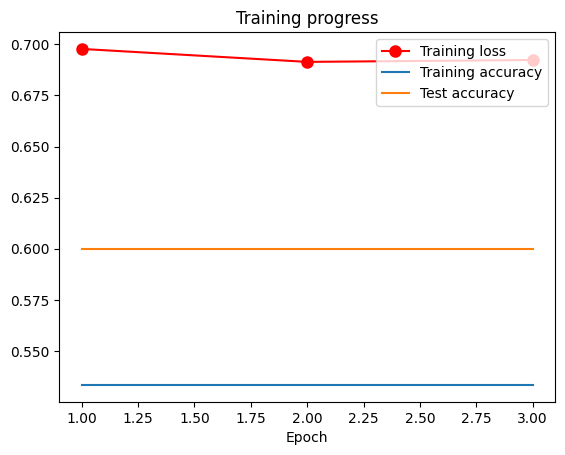

In [206]:
# Configure model training hyper parameters
config = {
    "epochs": 3,
    "lr": 0.1,
    "batch_size": 25,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 10,
}

# Train and plot the results

classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

In [207]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

In [208]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

Submission received. Autograder in progress.


In [64]:
client.await_autograder_result(submission_id=submission_id)

{'_id': '6709a7ee60dfd305cf9bbabb',
 'submittedBy': 'ganiyubaraq@gmail.com',
 'status': 'succeeded',
 'statusMessage': 'Submission graded successfully.',
 'executionId': 'ionq-scquantum-wtr94',
 'executionSec': 75,
 'score': 62,
 'createdAt': '2024-10-11T22:34:24.028Z',
 'updatedAt': '2024-10-11T22:34:24.028Z',
 'success': True}